<a href="https://colab.research.google.com/github/rajadevineni/Image_Denoising_autoencoder/blob/master/Convolutional_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Convolutional Autoencoder***

## ***Loading Libraries and Dataset***

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## **Add noise into the dataset**



> 

1.   We generate synthetic gausian noise through np.random.normal
2.   After adding the noise the values in image matrix are no longer between 0 & 1. Hence, we clip the images between 0, 1






In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

# Building for only single channel image data format
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

# Adding noise to the original dataset
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

11493376/11490434 [==============================] - 0s 0us/step


## **Visualize few samples**

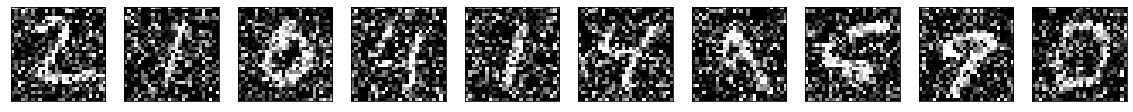

In [3]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# **Building Convolutional Autoencoder**



*   **This encoder is made for MNIST dataset which has only grayscale images**
*   **Configure this net to accomodate different dimensions of images**



In [4]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# **Training the model**



*   **While fitting the model I've set "*shuffle = True*", this many result in longer 
time for the model to train**

> shuffle: Logical (whether to shuffle the training data before each epoch) or string (for "batch"). "batch" is a special option for dealing with the limitations of HDF5 data; it shuffles in batch-sized chunks. Has no effect when steps_per_epoch is not NULL.


In [5]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks = [es])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 130s 2ms/step - loss: 0.1764 - val_loss: 0.1318
Epoch 2/100
60000/60000 [==============================] - 129s 2ms/step - loss: 0.1194 - val_loss: 0.1198
Epoch 3/100
60000/60000 [==============================] - 129s 2ms/step - loss: 0.1123 - val_loss: 0.1090
Epoch 4/100
60000/60000 [==============================] - 130s 2ms/step - loss: 0.1083 - val_loss: 0.1067
Epoch 5/100
60000/60000 [==============================] - 130s 2ms/step - loss: 0.1058 - val_loss: 0.1032
Epoch 6/100
60000/60000 [==============================] - 130s 2ms/step - loss: 0.1041 - val_loss: 0.1029
Epoch 7/100
60000/60000 [==============================] - 131s 2ms/step - loss: 0.1028 - val_loss: 0.1010
Epoch 8/100
60000/60000 [==============================] - 130s 2ms/step - loss: 0.1019 - val_loss: 0.0997
Epoch 9/100
60000/60000 [==============================] - 130s 2ms/step - loss: 0.1011 - val_

## Model Summary 




In [6]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0   

# **Evaluating the model**

In [7]:
evaluation = autoencoder.evaluate(x_test_noisy.reshape(-1,28,28,1), x_test.reshape(-1,28,28,1))

10000/10000 [==============================] - 6s 594us/step


In [8]:
#autoencoder.evaluate(x_test_noisy.reshape(-1,28,28,1), x_test.reshape(-1,28,28,1))
print(autoencoder.evaluate(x_test_noisy,x_test))

10000/10000 [==============================] - 6s 593us/step
0.09926765601634979


## **Predict 10 images**

In [9]:
#predicted = autoencoder.predict(x_test_noisy[:10].reshape(-1,28,28,1))
predicted = autoencoder.predict(x_test_noisy[:10])

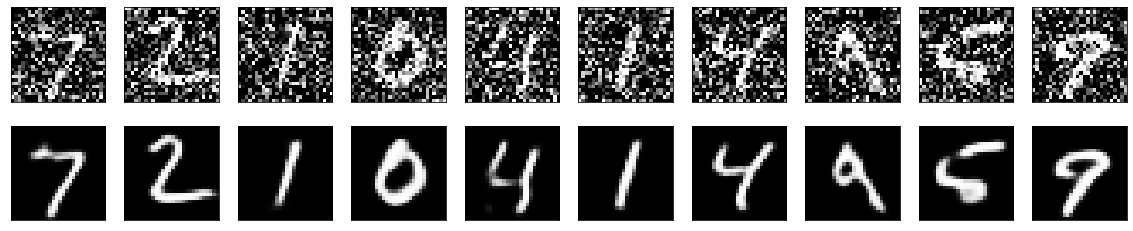

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey= True, figsize = (20,4))

for images, row in zip([x_test_noisy[:10], predicted], axes):
  for img, ax in zip(images,row):
    ax.imshow(img.reshape(28,28), cmap ='Greys_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Save the model

In [ ]:
autoencoder.save("auto_encoder")